Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 114MB/s]


Streaming output truncated to the last 5000 lines.
Entropy: 2.8304683502310635
Entropy: 1.6253785496437985
Entropy: 1.1488348542809166
Information Gain: 0.14719105447049197
Entropy: 3.0
Entropy: 2.9248387965202696
Entropy: 2.751811295670004
Entropy: 2.3868392966712704
Entropy: 1.0
Information Gain: 0.15528225475893098
Entropy: 3.0
Entropy: 2.8983655846907252
Entropy: 2.884408222906493
Entropy: 2.1186321541597515
Entropy: 1.2806721295208872
Information Gain: 0.20950736724769703
Entropy: 3.0
Entropy: 2.5683668516916174
Entropy: 2.9302333803233647
Entropy: 2.6483492322296254
Entropy: 2.1179631753145163
Information Gain: 0.2520648632206952
Entropy: 3.0
Entropy: 2.9361863692349335
Entropy: 2.6522851158487386
Entropy: 1.7892565059205938
Entropy: 1.584962500721156
Information Gain: 0.20718047123050587
Entropy: 3.0
Entropy: 2.9710034598237507
Entropy: 2.81184750973273
Entropy: 2.125490522174914
Entropy: 1.1488348542809166
Information Gain: 0.11897070609371951
Entropy: 3.0
Entropy: 2.9954659077

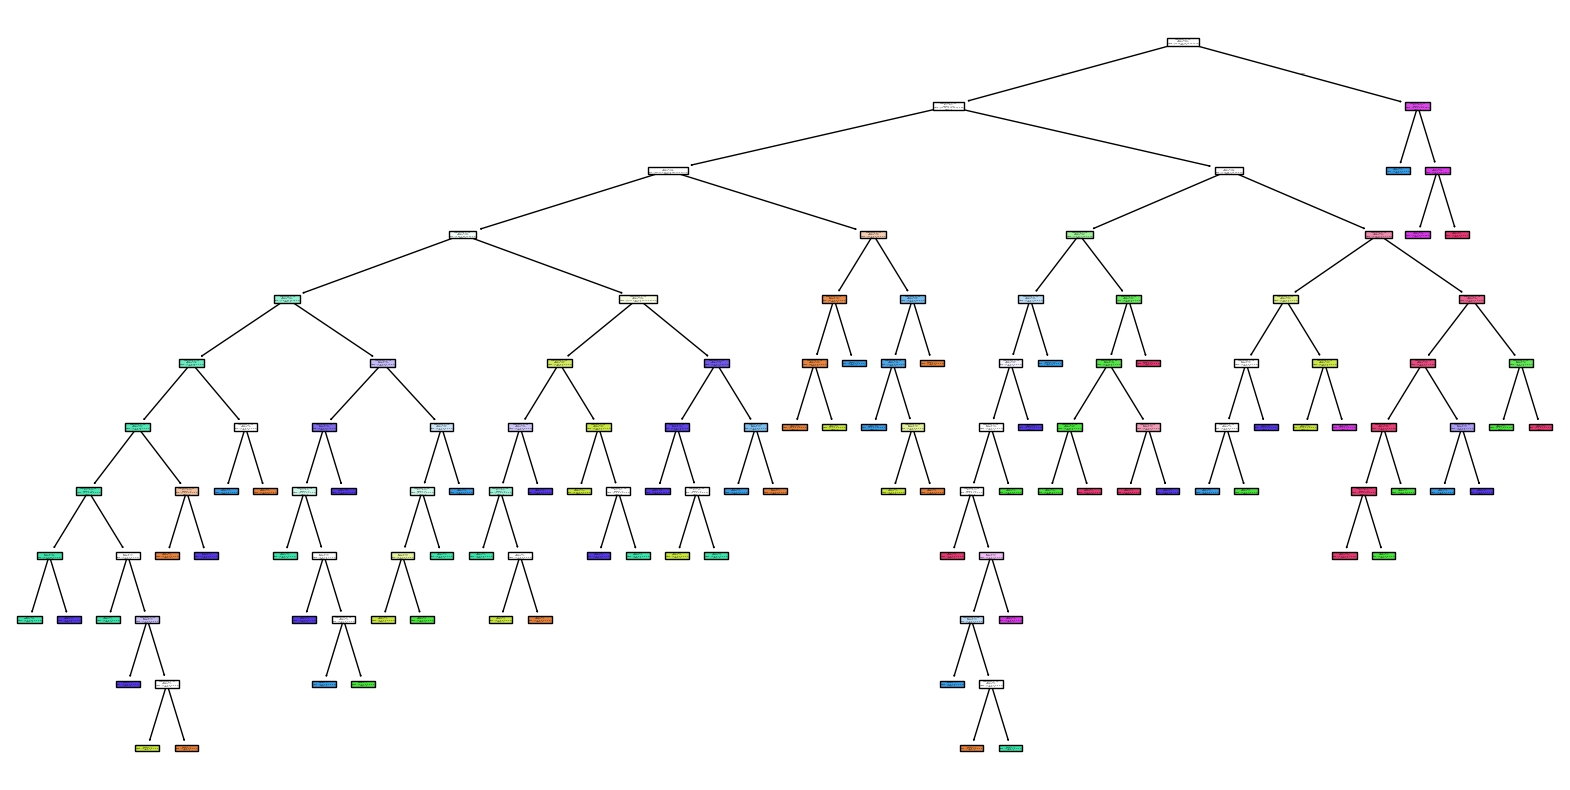

Decision Tree Accuracy: 0.5750


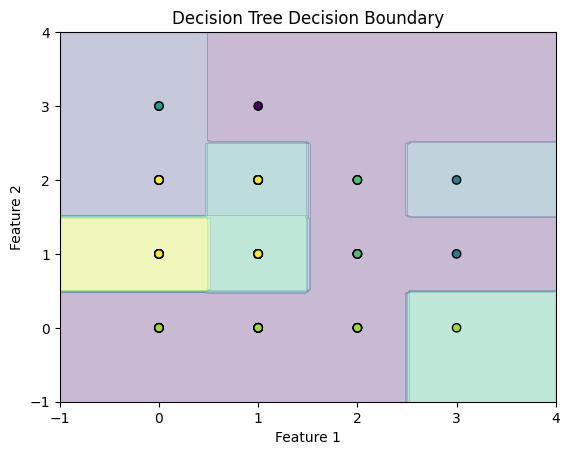

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Load Dataset from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Path to dataset
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/flowers"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "validation")

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Pretrained ResNet-50 Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove final FC layer
model.eval()
model.to(device)

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                if os.path.isfile(img_path):
                    self.image_paths.append(img_path)
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Extract Features
def extract_features(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features, labels = [], []

    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            output = model(images)
            output = output.view(output.size(0), -1)
            features.append(output.cpu().numpy())
            labels.append(lbls.numpy())

    return np.vstack(features), np.hstack(labels)

# Load Dataset & Extract Features
train_dataset = ImageDataset(TRAIN_DIR, transform)
val_dataset = ImageDataset(VAL_DIR, transform)

X_train, y_train = extract_features(train_dataset)
X_test, y_test = extract_features(val_dataset)

#A1
# Function for Equal Width Binning
def equal_width_binning(data, bins=4):
    binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    return binner.fit_transform(data.reshape(-1, 1)).flatten()

# Function to Compute Entropy
def entropy(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    ent = -np.sum(probs * np.log2(probs))
    print(f"Entropy: {ent}")
    return ent

#A2
# Function to Compute Gini Index
def gini_index(y):
    values, counts = np.unique(y, return_counts=True)
    probs = counts / len(y)
    gini = 1 - np.sum(probs ** 2)
    print(f"Gini Index: {gini}")
    return gini

#A3
# Function to Compute Information Gain
def information_gain(X, y):
    total_entropy = entropy(y)
    values, counts = np.unique(X, return_counts=True)
    weighted_entropy = sum((counts[i] / len(X)) * entropy(y[X == v]) for i, v in enumerate(values))
    gain = total_entropy - weighted_entropy
    print(f"Information Gain: {gain}")
    return gain

# Function to Find Best Feature for Decision Tree Root
def best_split(X, y):
    gains = [information_gain(X[:, i], y) for i in range(X.shape[1])]
    best_feature = np.argmax(gains)
    print(f"Best Feature Index: {best_feature}")
    return best_feature

# Convert Continuous Features to Categorical
X_train_binned = np.apply_along_axis(equal_width_binning, 0, X_train)
X_test_binned = np.apply_along_axis(equal_width_binning, 0, X_test)

# Call Functions to Display Outputs
print("Calculating Entropy:")
entropy(y_train)
print("\nCalculating Gini Index:")
gini_index(y_train)
print("\nCalculating Information Gain:")
information_gain(X_train_binned[:, 0], y_train)
print("\nFinding Best Feature:")
best_split(X_train_binned, y_train)

#A5
# Build Decision Tree Model
dt = DecisionTreeClassifier()
dt.fit(X_train_binned, y_train)

#A6
# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=[f"Feature {i}" for i in range(X_train.shape[1])], class_names=[str(i) for i in np.unique(y_train)])
plt.show()

# Predict and Compute Accuracy
y_pred = dt.predict(X_test_binned)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.4f}")

#A7
# Decision Boundary Visualization
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Tree Decision Boundary")
    plt.show()

# Select Two Features for Visualization
X_train_2D = X_train_binned[:, :2]
X_test_2D = X_test_binned[:, :2]

# Train Decision Tree on Two Features
dt_2D = DecisionTreeClassifier()
dt_2D.fit(X_train_2D, y_train)

# Plot Decision Boundary
plot_decision_boundary(dt_2D, X_test_2D, y_test)